# Fused Lasso
- Author: Yuege Xie (EID:yx4256)
- Python version: Python 3
- The file should be stored in the same file folder of the data.

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
%matplotlib inline

# check the python version
from platform import python_version
print("Current python version is {}".format(python_version()))

Current python version is 3.6.7


In [2]:
# def function to create matrix D
def create_D(n):
    D = diags([-1, 1], [0, 1], shape=(n-1,n)).toarray()
    return D

In [3]:
# test the create matrix function
create_D(4)

array([[-1.,  1.,  0.,  0.],
       [ 0., -1.,  1.,  0.],
       [ 0.,  0., -1.,  1.]])

In [4]:
def subgradient(x, z, eta, lam, D):
    p = np.sign(np.dot(D,x))
    #p[p==0] = 1e-1 #if we change the value for subgradient#
    subg = x - z + lam * np.dot(D.T, p)
    x = x - eta*subg
    return x  

In [5]:
def loss_p(x, z, lam, D):
    loss = 0.5*np.linalg.norm(x-z, ord=2)**2 + lam * np.linalg.norm(np.dot(D,x), ord=1)
    return loss

In [6]:
def descent_p(update, z, dec=0, eta=0.01, lam=0.01, T=int(1e3), gap=5000):
    
    # define parameters
    n = z.shape[0]
    D = create_D(n)
    
    # initialization
    np.random.seed(1023)
    x = np.random.randn(n)
    train_err = []
    eta0 = eta
    
    for t in range(T):
        
        if (t % 1 == 0) or (t == T - 1):
            train_err.append(loss_p(x, z, lam, D))
 
            assert not np.isnan(train_err[-1])
            
        if (t % gap == 0) or (t == T - 1):
            print("iteration = {}: train loss = {}".format(t, train_err[t]))
         
        if dec==1:
            eta = eta0 / (np.sqrt(t)+1.0)
        elif dec==2:
            eta = eta0 / (t+ 1.0)
        
        x = update(x, z, eta, lam, D)
            
    return x, train_err

In [7]:
# read data
z = np.genfromtxt('./noisy.txt', delimiter='')
z.shape

(1571,)

In [8]:
def p_c(z, low, up, lam, pic, T=int(1e3)):
    
    plt.clf()
    plt.title('Training Error for Fused Lasso using Subgradient Descent')
    plt.xlabel('iteration')
    plt.ylabel('error')
    
    for i in range(low, up):
        eta = 10**i
        
        
        print('Training for stepsize = {}'.format(eta))
        x, err = descent_p(subgradient, z, eta=eta, lam=lam, T=T)
        plt.plot(err, label = '$\eta$={}'.format(eta))
    
    print('Training for stepsize = $1/\sqrt{t}$')
    x, err = descent_p(subgradient, z, dec=1, eta=1, lam=lam, T=T)
    plt.plot(err, label = '$\eta = 1/\sqrt{t}$')
    
    print('Training for stepsize = 1/t')
    x, err = descent_p(subgradient, z, dec=2, eta=1, lam=lam, T=T)
    plt.plot(err, label = '$\eta = 1/t$')
        
    plt.legend(loc=0)
    plt.savefig(pic) 
    plt.show()
    

Training for stepsize = 0.001
iteration = 0: train loss = 1178.3506535937022
iteration = 4999: train loss = 1.6216123627927812
Training for stepsize = 0.01
iteration = 0: train loss = 1178.3506535937022
iteration = 4999: train loss = 1.581307296517153
Training for stepsize = 0.1
iteration = 0: train loss = 1178.3506535937022
iteration = 4999: train loss = 1.5826596547529206
Training for stepsize = 1
iteration = 0: train loss = 1178.3506535937022
iteration = 4999: train loss = 1.6546539175640005
Training for stepsize = $1/\sqrt{t}$
iteration = 0: train loss = 1178.3506535937022
iteration = 4999: train loss = 1.5813622317331333
Training for stepsize = 1/t
iteration = 0: train loss = 1178.3506535937022
iteration = 4999: train loss = 1.5811810055599784


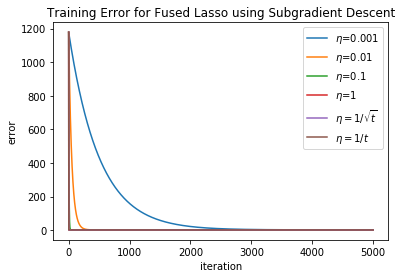

In [9]:
p_c(z, low=-3, up=1, lam=0.01, T=5000, pic="pc001.pdf")

Training for stepsize = 0.001
iteration = 0: train loss = 2998.565092884539
iteration = 4999: train loss = 16.31092689017963
Training for stepsize = 0.01
iteration = 0: train loss = 2998.565092884539
iteration = 4999: train loss = 32.144156333839405
Training for stepsize = 0.1
iteration = 0: train loss = 2998.565092884539
iteration = 4999: train loss = 307.25881648638904
Training for stepsize = 1
iteration = 0: train loss = 2998.565092884539
iteration = 4999: train loss = 7592.3686367598
Training for stepsize = $1/\sqrt{t}$
iteration = 0: train loss = 2998.565092884539
iteration = 4999: train loss = 44.035942189945835
Training for stepsize = 1/t
iteration = 0: train loss = 2998.565092884539
iteration = 4999: train loss = 15.821137747008507


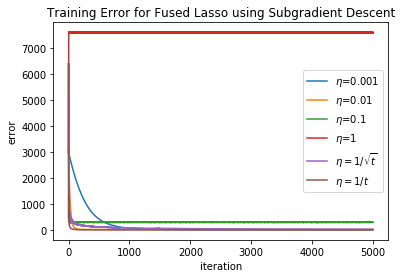

In [10]:
p_c(z, low=-3, up=1, lam=1, T=5000, pic="pc1.pdf")

In [11]:
def proximal(u, z, eta, lam, D):
    grad = np.dot(D, np.dot(D.T, u) - z)
    u = u - eta*grad
    u[u>lam]  = lam
    u[u<-lam] = -lam
    return u

In [12]:
def loss_d(u, z, D):
    loss = 0.5*np.linalg.norm(np.dot(D.T, u),ord=2)**2 - np.dot(u, np.dot(D, z))
    return loss

In [13]:
def descent_d(update, z, eta=0.01, lam=0.1, T=int(1e3), gap=5000):
    # define parameters
    n = z.shape[0]
    D = create_D(n)
    
    # initialization
    np.random.seed(1023)
    u = np.random.randn(n-1)
    u[u>lam]  = lam
    u[u<-lam] = -lam
    train_err = []
    
    for t in range(T):
        
        if (t % 1 == 0) or (t == T - 1):
            train_err.append(loss_d(u, z, D))
 
            assert not np.isnan(train_err[-1])
            
        if (t % gap == 0) or (t == T - 1):
            print("iteration = {}: train loss = {}".format(t, train_err[t]))
            
        u = update(u, z, eta, lam, D)
    
    # get x from dual problem
    x = z - np.dot(D.T, u)
            
    return x, train_err

In [14]:
def p_e(z, pic, eta=0.1, lam=0.1, T=200):
    
    plt.figure(1, figsize=(10,4))
    
    x, err = descent_p(subgradient, z=z, eta=eta, lam=lam, T=T)
    plt.subplot(121)
    plt.plot(err, label = 'subgradient')
    plt.xlabel('iteration')
    plt.ylabel('error')
    plt.legend(loc=0)
    
    x, err = descent_d(proximal, z=z, eta=eta, lam=lam, T=T)
    plt.subplot(122)
    plt.plot(err, label = 'proximal GD')
    plt.xlabel('iteration')
    plt.ylabel('error')
    plt.legend(loc=0)
    
    plt.savefig(pic) 
    plt.show()

iteration = 0: train loss = 1343.8246935292327
iteration = 199: train loss = 7.966650761303275
iteration = 0: train loss = 14.180355836010536
iteration = 199: train loss = -6.645679484435253


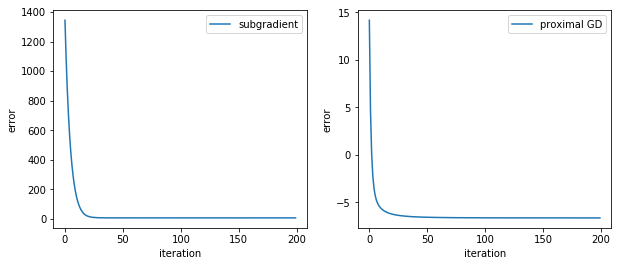

In [15]:
p_e(z, eta=0.1, T=200, pic="pe01.pdf")

iteration = 0: train loss = 1343.8246935292327
iteration = 199: train loss = 21.172880280052958
iteration = 0: train loss = 14.180355836010536
iteration = 199: train loss = -6.241281882854572


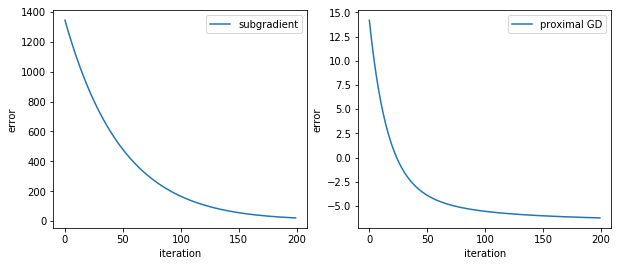

In [16]:
p_e(z, eta=0.01, T=200, pic="pe001.pdf")

In [17]:
def p_f(z, low, up, eta, T=int(1e3)):
    
    plt.figure(1, figsize=(12,8))
    k = 1
    
    for i in range(low, up):
        lam = 10**i
        plt.subplot(2, 2, k)
        print('Training for lambda = {}'.format(lam))
        x, err = descent_d(proximal, z, eta, lam, T)
        plt.plot(z, label = 'nosiy')
        plt.plot(x, label = '$\lambda$={}'.format(lam))
        plt.legend(loc=0)
        k = k+1
    
    plt.savefig('pf.pdf')
    plt.show()

Training for lambda = 0.01
iteration = 0: train loss = 0.05258749095629675
iteration = 4999: train loss = -1.5811783745924914
Training for lambda = 0.1
iteration = 0: train loss = 14.180355836010536
iteration = 4999: train loss = -6.64635802582867
Training for lambda = 1
iteration = 0: train loss = 830.7859231167294
iteration = 4999: train loss = -11.19307834948326
Training for lambda = 10
iteration = 0: train loss = 1649.2726559469118
iteration = 4999: train loss = -11.05982120959548


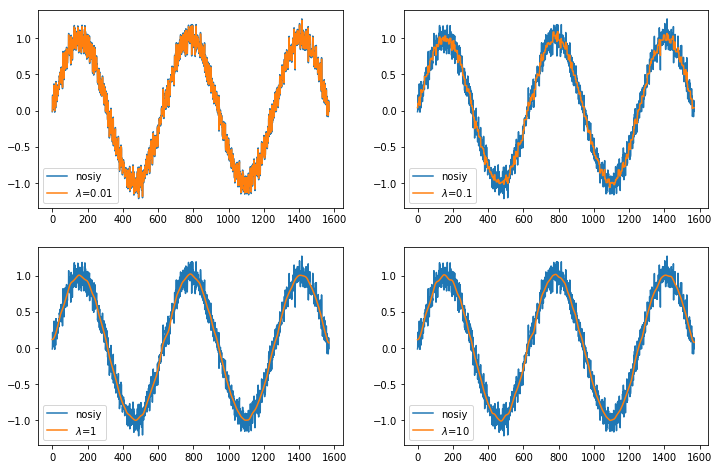

In [18]:
p_f(z, low=-2, up=2, eta=0.01, T=5000)